<a href="https://colab.research.google.com/github/mk7890/Machine-Learning-II/blob/main/ML2_CustomerSegmentationDataset_KMeansClustering_exiercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV



Loading the Dataset

In [2]:
!kaggle datasets download -d yasserh/customer-segmentation-dataset

Dataset URL: https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset
License(s): CC0-1.0
 92% 20.0M/21.8M [00:00<00:00, 206MB/s]
100% 21.8M/21.8M [00:00<00:00, 214MB/s]


In [3]:
import zipfile
zipfile_path = '/content/customer-segmentation-dataset.zip'
csv_file = zipfile_path.replace('zip', '')
with zipfile.ZipFile(zipfile_path, 'r') as file:
  file.extractall()
  print('Done')

Done


In [4]:
df=pd.read_excel('/content/Online Retail.xlsx')

df.to_csv('Online Retail.csv', index=False)

In [5]:
#df=pd.read_csv('/content/Online Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [8]:
df=df.dropna()

In [9]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [10]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
# Check for duplicates
duplicates = df.duplicated().sum()

# Check for missing values
missing_values = df.isnull().sum()

# Check data types
data_types = df.dtypes

# Summary statistics for numerical columns
summary_stats = df.describe()

# Display results
print("Missing Values:\n", missing_values)
print("\nDuplicates: ", duplicates)
print("\nData Types:\n", data_types)
print("\nSummary Statistics:\n", summary_stats)

Missing Values:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Duplicates:  5225

Data Types:
 InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Summary Statistics:
             Quantity                    InvoiceDate      UnitPrice  \
count  406829.000000                         406829  406829.000000   
mean       12.061303  2011-07-10 16:30:57.879207424       3.460471   
min    -80995.000000            2010-12-01 08:26:00       0.000000   
25%         2.000000            2011-04-06 15:02:00       1.250000   
50%         5.000000            2011-07-31 11:48:00       1.950000   
75%        12.000000            2011-10-20 13:06:00       3.750000   
max     80995.000000            201

Feature Engineering

In [12]:
# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create 'TotalPrice' feature
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Extract temporal features from 'InvoiceDate'
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.weekday

# Handle any negative quantities or prices (if they exist)
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Aggregate features at the customer level
customer_agg = df.groupby('CustomerID').agg(
    TotalSpend=('TotalPrice', 'sum'),
    TotalPurchases=('InvoiceNo', 'nunique'),
    AverageBasketSize=('Quantity', 'mean'),
    Recency=('InvoiceDate', lambda x: (df['InvoiceDate'].max() - x.max()).days),
    Frequency=('InvoiceNo', 'count'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

# Check the aggregated customer data
print(customer_agg.head())


   CustomerID  TotalSpend  TotalPurchases  AverageBasketSize  Recency  \
0     12346.0    77183.60               1       74215.000000      325   
1     12347.0     4310.00               7          13.505495        1   
2     12348.0     1797.24               4          75.516129       74   
3     12349.0     1757.55               1           8.643836       18   
4     12350.0      334.40               1          11.588235      309   

   Frequency  Monetary  
0          1  77183.60  
1        182   4310.00  
2         31   1797.24  
3         73   1757.55  
4         17    334.40  


Data Cleaning

In [13]:
# Remove any rows with negative or zero quantities and prices
df_cleaned = df[df['Quantity'] > 0]
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]

# Remove duplicates
df_cleaned = df_cleaned.drop_duplicates()

# Check the shape of the cleaned dataset
print("Cleaned Data Shape: ", df_cleaned.shape)


Cleaned Data Shape:  (392692, 14)


Cheking for Outliers

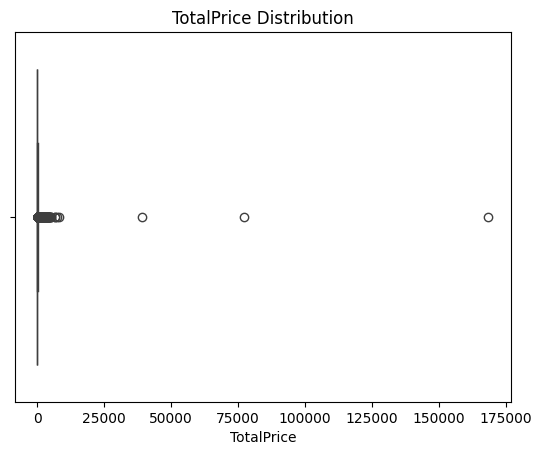

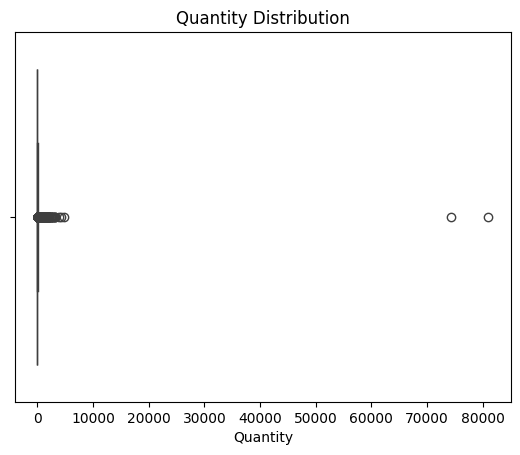

In [14]:

# Visualize outliers in 'TotalPrice' and 'Quantity'
sns.boxplot(x=df_cleaned['TotalPrice'])
plt.title('TotalPrice Distribution')
plt.show()

sns.boxplot(x=df_cleaned['Quantity'])
plt.title('Quantity Distribution')
plt.show()


# Customer Segmentation using clustering

Normalization

In [15]:



# Select the relevant columns for clustering
customer_features = customer_agg[['TotalSpend', 'TotalPurchases', 'AverageBasketSize', 'Recency', 'Frequency', 'Monetary']]

# Standardize the data
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_features)

# Check the scaled data
print(customer_scaled[:5])


[[ 8.35866818e+00 -4.25096503e-01  6.16388071e+01  2.33457414e+00
  -3.96577702e-01  8.35866818e+00]
 [ 2.50966264e-01  3.54416797e-01 -2.62279345e-02 -9.05340320e-01
   3.94648958e-01  2.50966264e-01]
 [-2.85960063e-02 -3.53398530e-02  2.53059056e-02 -1.75359593e-01
  -2.65435162e-01 -2.85960063e-02]
 [-3.30117987e-02 -4.25096503e-01 -3.02682085e-02 -7.35344808e-01
  -8.18356055e-02 -3.30117987e-02]
 [-1.91347273e-01 -4.25096503e-01 -2.78212697e-02  2.17457836e+00
  -3.26635014e-01 -1.91347273e-01]]


Apply K-Means Clustering

In [16]:

# Determine the optimal number of clusters using the Elbow Method
inertia = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_scaled, kmeans.labels_))




In [18]:
from sklearn.cluster import KMeans

# Assuming KMeans was run on your data
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(customer_agg)  # Replace `customer_agg` with the appropriate DataFrame or data matrix

# Add cluster labels to the DataFrame
customer_agg['Cluster'] = kmeans.labels_


In [20]:
print(customer_agg.head())


   CustomerID  TotalSpend  TotalPurchases  AverageBasketSize  Recency  \
0     12346.0    77183.60               1       74215.000000      325   
1     12347.0     4310.00               7          13.505495        1   
2     12348.0     1797.24               4          75.516129       74   
3     12349.0     1757.55               1           8.643836       18   
4     12350.0      334.40               1          11.588235      309   

   Frequency  Monetary  Cluster  
0          1  77183.60        2  
1        182   4310.00        0  
2         31   1797.24        0  
3         73   1757.55        0  
4         17    334.40        0  


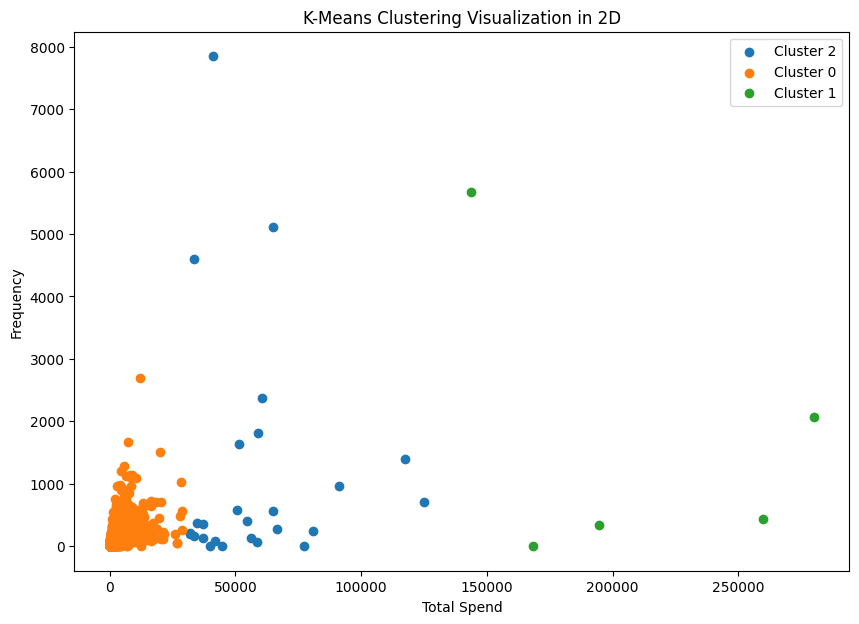

In [21]:
X = customer_agg[['TotalSpend', 'Frequency']]  # Replace with your actual feature names
clusters = customer_agg['Cluster']

plt.figure(figsize=(10, 7))
for cluster in clusters.unique():
    plt.scatter(X[clusters == cluster].iloc[:, 0],
                X[clusters == cluster].iloc[:, 1],
                label=f'Cluster {cluster}')

plt.title('K-Means Clustering Visualization in 2D')
plt.xlabel('Total Spend')
plt.ylabel('Frequency')
plt.legend()
plt.show()


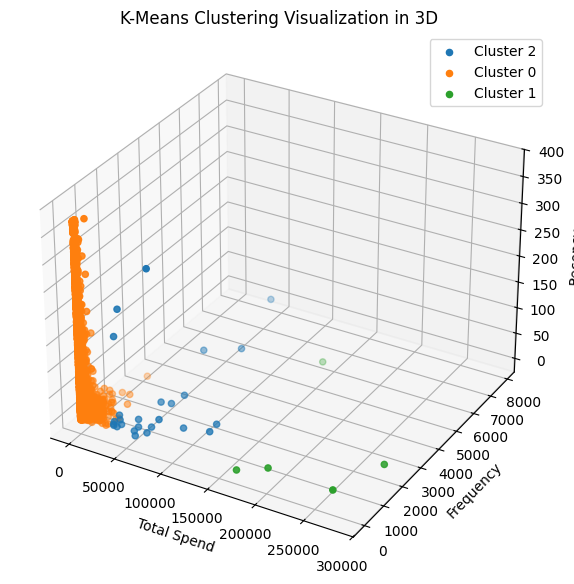

In [22]:
from mpl_toolkits.mplot3d import Axes3D

X_3D = customer_agg[['TotalSpend', 'Frequency', 'Recency']]  # Replace with your actual feature names
clusters = customer_agg['Cluster']

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for cluster in clusters.unique():
    ax.scatter(X_3D[clusters == cluster].iloc[:, 0],
               X_3D[clusters == cluster].iloc[:, 1],
               X_3D[clusters == cluster].iloc[:, 2],
               label=f'Cluster {cluster}')

ax.set_title('K-Means Clustering Visualization in 3D')
ax.set_xlabel('Total Spend')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')
ax.legend()
plt.show()


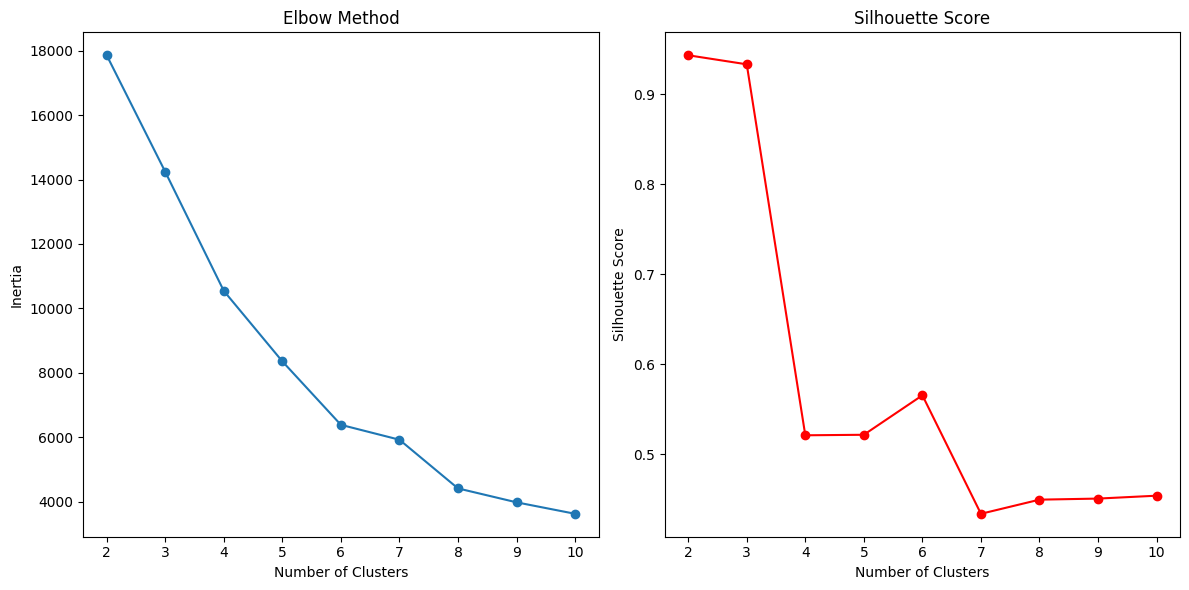

In [23]:
# Plot the Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o', color='r')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()



In [24]:
# Choose optimal number of clusters (e.g., 4 based on elbow method)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_agg['Cluster'] = kmeans.fit_predict(customer_scaled)

# Show cluster centers
print("Cluster Centers: \n", kmeans.cluster_centers_)

Cluster Centers: 
 [[-6.41093480e-03  7.24204408e-02 -2.10775615e-02 -5.19212948e-01
   4.63695270e-02 -6.41093480e-03]
 [ 1.18741635e+01  9.20418543e+00  1.33337052e+00 -8.58870958e-01
   9.49799840e+00  1.18741635e+01]
 [ 8.35866818e+00 -4.25096503e-01  6.16388071e+01  2.33457414e+00
  -3.96577702e-01  8.35866818e+00]
 [-1.71292787e-01 -3.51158927e-01 -1.49809403e-02  1.51806453e+00
  -2.80085533e-01 -1.71292787e-01]]


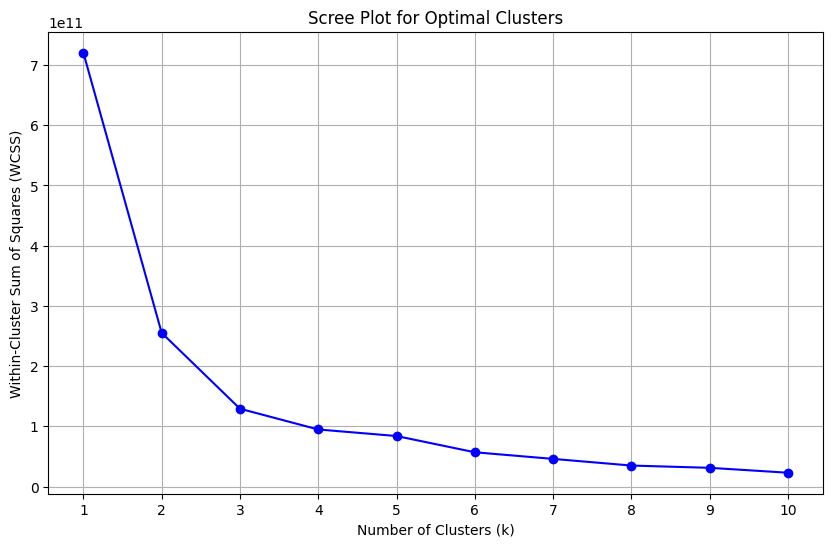

In [25]:
# Define a range for the number of clusters
cluster_range = range(1, 11)

# List to store the WCSS values
wcss = []

# Calculate WCSS for each number of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_agg)  # Replace with your DataFrame or feature matrix
    wcss.append(kmeans.inertia_)  # kmeans.inertia_ is the WCSS for the current k

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Scree Plot for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(cluster_range)
plt.grid()
plt.show()


Cluster Profiling

In [26]:
# Analyze the average characteristics of each cluster
cluster_profile = customer_agg.groupby('Cluster').mean()
print(cluster_profile)


           CustomerID     TotalSpend  TotalPurchases  AverageBasketSize  \
Cluster                                                                   
0        15280.647260    1997.078158        4.829701          19.706042   
1        15138.176471  108781.555294       75.117647        1649.509389   
2        12346.000000   77183.600000        1.000000       74215.000000   
3        15362.848375     514.731788        1.571300          27.023368   

            Recency    Frequency       Monetary  
Cluster                                          
0         39.582503   102.350872    1997.078158  
1          5.647059  2264.470588  108781.555294  
2        325.000000     1.000000   77183.600000  
3        243.253610    27.649819     514.731788  
